In [1]:
import pandas as pd
import numpy as np

# PyTorch and PyTorch Geometric imports
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

# For splitting the data
from sklearn.model_selection import train_test_split

# For building the GNN
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.optim import Adam

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Libraries imported successfully.")

# --- Load the data we've processed so far ---
# We need the customers (with features) and the relationships
try:
    # Let's re-run the feature engineering part to get the customers_df
    # (This ensures the notebook is self-contained)

    # Load raw data
    customers_df = pd.read_csv('customers.csv')
    merchants_df = pd.read_csv('merchants.csv')
    transactions_df = pd.read_csv('transactions.csv', parse_dates=['timestamp'])
    relationships_df = pd.read_csv('relationships.csv')
    ground_truth_df = pd.read_csv('stressed_customers_ground_truth.csv')

    # Create target variable
    customers_df['is_stressed'] = customers_df['customer_id'].isin(ground_truth_df['customer_id']).astype(int)

    # Feature 1: Late Salary Count
    salary_df = transactions_df[transactions_df['merchant_id'] == 'SALARY'].copy()
    salary_df['day'] = salary_df['timestamp'].dt.day
    baseline_salary_day = salary_df.groupby('customer_id')['day'].median().to_dict()
    def is_late(row):
        customer_baseline = baseline_salary_day.get(row['customer_id'])
        if customer_baseline is None: return 0
        return 1 if row['day'] > customer_baseline + 2 else 0
    salary_df['is_late_salary'] = salary_df.apply(is_late, axis=1)
    late_salary_counts = salary_df.groupby('customer_id')['is_late_salary'].sum().reset_index()
    late_salary_counts.rename(columns={'is_late_salary': 'feature_late_salary_count'}, inplace=True)
    customers_df = pd.merge(customers_df, late_salary_counts, on='customer_id', how='left').fillna(0)

    # Feature 2: Lending App Transaction Count
    lending_app_ids = merchants_df[merchants_df['category'] == 'LendingApp']['merchant_id'].tolist()
    lending_transactions = transactions_df[transactions_df['merchant_id'].isin(lending_app_ids)]
    lending_tx_counts = lending_transactions.groupby('customer_id').size().reset_index(name='feature_lending_app_tx_count')
    customers_df = pd.merge(customers_df, lending_tx_counts, on='customer_id', how='left').fillna(0)

    print("\n--- Data Loaded and Features Re-created ---")
    print("Customer data with features:")
    print(customers_df.head())

except FileNotFoundError as e:
    print(f"ERROR: Make sure the CSV files from Phase 1 are in the same folder.")



C:\Users\DIWANSU PILANIA\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.

--- Data Loaded and Features Re-created ---
Customer data with features:
  customer_id  is_stressed  feature_late_salary_count  \
0       C0000            0                       12.0   
1       C0001            0                       20.0   
2       C0002            0                       16.0   
3       C0003            1                       14.0   
4       C0004            0                       15.0   

   feature_lending_app_tx_count  
0                          27.0  
1                          34.0  
2                          18.0  
3                          20.0  
4                          24.0  


In [2]:
# --- Graph Construction ---

# We only use customers as nodes for this model
# Create a mapping from customer_id to a unique integer index (0, 1, 2, ...)
customer_id_map = {customer_id: i for i, customer_id in enumerate(customers_df['customer_id'])}
num_nodes = len(customer_id_map)

# --- Define Node Features (x) ---
# These are the signals our GNN will use to learn.
# We must use only numerical features.
feature_columns = ['feature_late_salary_count', 'feature_lending_app_tx_count']
node_features = customers_df.sort_values('customer_id')[feature_columns].values

# Convert to a PyTorch tensor
x = torch.tensor(node_features, dtype=torch.float)

# --- Define Node Labels (y) ---
# This is the ground truth (is_stressed or not) for each node.
node_labels = customers_df.sort_values('customer_id')['is_stressed'].values
y = torch.tensor(node_labels, dtype=torch.long)

# --- Define Edges (edge_index) ---
# An edge exists if two customers have a relationship.
# We need to convert the customer_ids in relationships_df to our new integer indices.
source_nodes = relationships_df['customer_id_1'].map(customer_id_map)
target_nodes = relationships_df['customer_id_2'].map(customer_id_map)

# PyG expects the edge index in a specific shape: [2, num_edges]
# We also add edges in the other direction to make the graph undirected.
edge_index = torch.tensor([
    np.concatenate([source_nodes.values, target_nodes.values]),
    np.concatenate([target_nodes.values, source_nodes.values])
], dtype=torch.long)

# --- Create Masks for Training, Validation, and Testing ---
# We don't train the model on all the data. We hide some nodes (test set)
# to evaluate how well the model generalizes to unseen data.
indices = list(range(num_nodes))
train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=y)
train_indices, val_indices = train_test_split(train_indices, test_size=0.15, stratify=y[train_indices])

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

# --- Assemble the Graph Data Object ---
graph_data = Data(x=x, edge_index=edge_index, y=y,
                  train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

print("\n--- Graph Construction Complete! ---")
print("PyTorch Geometric Data object:")
print(graph_data)
print(f"\nNumber of nodes: {graph_data.num_nodes}")
print(f"Number of edges: {graph_data.num_edges}")
print(f"Number of features per node: {graph_data.num_node_features}")
print(f"Training nodes: {graph_data.train_mask.sum().item()}")
print(f"Validation nodes: {graph_data.val_mask.sum().item()}")
print(f"Test nodes: {graph_data.test_mask.sum().item()}")



--- Graph Construction Complete! ---
PyTorch Geometric Data object:
Data(x=[1000, 2], edge_index=[2, 19596], y=[1000], train_mask=[1000], val_mask=[1000], test_mask=[1000])

Number of nodes: 1000
Number of edges: 19596
Number of features per node: 2
Training nodes: 680
Validation nodes: 120
Test nodes: 200


C:\Users\DIWANSU PILANIA\AppData\Local\Temp\ipykernel_14308\961079699.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  edge_index = torch.tensor([


In [3]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden, num_classes):
        super(GCN, self).__init__()
        # First graph convolution layer
        self.conv1 = GCNConv(num_node_features, num_hidden)
        # Second graph convolution layer
        self.conv2 = GCNConv(num_hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Pass through the first layer
        x = self.conv1(x, edge_index)
        # Apply a non-linear activation function
        x = F.relu(x)
        # Apply dropout to prevent overfitting
        x = F.dropout(x, p=0.5, training=self.training)

        # Pass through the second layer
        x = self.conv2(x, edge_index)

        # Return the raw scores (logits) for each class
        return x

# Initialize the model
model = GCN(
    num_node_features=graph_data.num_node_features,
    num_hidden=16, # This is a hyperparameter you can tune
    num_classes=2  # (0: not-stressed, 1: stressed)
)

print("--- GNN Model Defined ---")
print(model)


--- GNN Model Defined ---
GCN(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 2)
)


In [4]:
# --- Model Training ---
optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    # Use the entire graph for prediction
    out = model(graph_data)
    # Calculate loss only on the training nodes
    loss = criterion(out[graph_data.train_mask], graph_data.y[graph_data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(mask):
    model.eval()
    with torch.no_grad():
        out = model(graph_data)
        pred = out.argmax(dim=1)
        correct = pred[mask] == graph_data.y[mask]
        acc = int(correct.sum()) / int(mask.sum())
    return acc

print("--- Starting Model Training ---")
for epoch in range(1, 201):
    loss = train()
    # Evaluate on the validation set to check for overfitting
    val_acc = evaluate(graph_data.val_mask)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Accuracy: {val_acc:.4f}')

print("\n--- Training Complete ---")


--- Starting Model Training ---
Epoch: 020, Loss: 0.6788, Val Accuracy: 0.8417
Epoch: 040, Loss: 0.5354, Val Accuracy: 0.8417
Epoch: 060, Loss: 0.5247, Val Accuracy: 0.8417
Epoch: 080, Loss: 0.4636, Val Accuracy: 0.8417
Epoch: 100, Loss: 0.4707, Val Accuracy: 0.8417
Epoch: 120, Loss: 0.4377, Val Accuracy: 0.8417
Epoch: 140, Loss: 0.4362, Val Accuracy: 0.8417
Epoch: 160, Loss: 0.4425, Val Accuracy: 0.8417
Epoch: 180, Loss: 0.4333, Val Accuracy: 0.8417
Epoch: 200, Loss: 0.4349, Val Accuracy: 0.8417

--- Training Complete ---



--- Final Model Performance on Test Data ---
Accuracy: 0.8450
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000


C:\Users\DIWANSU PILANIA\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


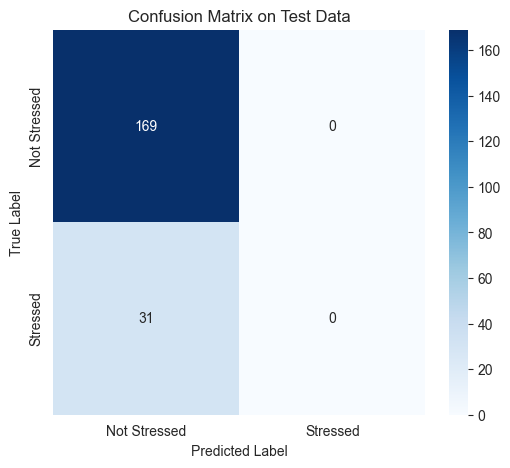

In [5]:
# --- Final Evaluation on the Test Set ---
model.eval()
with torch.no_grad():
    out = model(graph_data)
    pred = out.argmax(dim=1)

test_acc = accuracy_score(graph_data.y[graph_data.test_mask], pred[graph_data.test_mask])
test_precision = precision_score(graph_data.y[graph_data.test_mask], pred[graph_data.test_mask])
test_recall = recall_score(graph_data.y[graph_data.test_mask], pred[graph_data.test_mask])
test_f1 = f1_score(graph_data.y[graph_data.test_mask], pred[graph_data.test_mask])

print("\n--- Final Model Performance on Test Data ---")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Visualize the confusion matrix
cm = confusion_matrix(graph_data.y[graph_data.test_mask], pred[graph_data.test_mask])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Stressed', 'Stressed'], yticklabels=['Not Stressed', 'Stressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Data')
plt.show()


In [6]:
# Cell 9: Generate and Save GNN Network Features

print("\n--- Generating Network Features with Trained GNN ---")

# Ensure the model is in evaluation mode
model.eval()

# Get the final predictions (logits) from the GNN for ALL nodes
with torch.no_grad():
    final_logits = model(graph_data)

    # Apply softmax to convert logits to probabilities
    final_probabilities = F.softmax(final_logits, dim=1)

    # Our new feature is the probability of being in the "stressed" class (class 1)
    network_stress_feature = final_probabilities[:, 1].cpu().numpy()

# Create a new DataFrame with the customer IDs and their new network feature
gnn_features_df = pd.DataFrame({
    'customer_id': customers_df['customer_id'], # Assumes customers_df is sorted by customer_id
    'network_stress_feature': network_stress_feature
})

# Save these features to a CSV file
gnn_feature_filename = 'gnn_network_features.csv'
gnn_features_df.to_csv(gnn_feature_filename, index=False)

print(f"Successfully generated and saved GNN features to '{gnn_feature_filename}'.")
print("\nPreview of GNN features:")
print(gnn_features_df.head())



--- Generating Network Features with Trained GNN ---
Successfully generated and saved GNN features to 'gnn_network_features.csv'.

Preview of GNN features:
  customer_id  network_stress_feature
0       C0000                0.156444
1       C0001                0.158041
2       C0002                0.161637
3       C0003                0.161754
4       C0004                0.158204


In [7]:
# --- Save the trained model's state ---
model_save_path = "financial_stress_gnn.pth"
torch.save(model.state_dict(), model_save_path)

print(f"Model state dictionary saved to: {model_save_path}")


Model state dictionary saved to: financial_stress_gnn.pth
